In [62]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt

In [63]:
competition_math_dict = load_dataset("jeggers/competition_math", "original")
test_dataset = competition_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

In [64]:
def format_llema_inference_competition_math():
    file_path = "llemma_competition_math_extracted_answers_2.txt"
    with open(file_path, "r") as file:
        data = [eval(line.strip()) for line in file]
    df = pd.DataFrame(data)
    llema_test_dataset= df.merge(test_dataset_df, left_on='Iteration', right_on='row_index')
    llema_test_dataset["level:type"] = llema_test_dataset["level"] + ": " + llema_test_dataset["type"]

    llema_test_dataset["llema_is_correct"] =  (llema_test_dataset["Final Solution"] == llema_test_dataset["extracted_solution"])

    llema_test_dataset = llema_test_dataset.rename(columns={"Final Solution": "llema_solution"})

    llema_3_results = llema_test_dataset[["row_index", "level", "type", "llema_is_correct", "llema_solution"]]
    return llema_3_results

def format_mistral_inference_competition_math():
    df = pd.read_csv("Mistral_Inference_Competition_Dataset.csv")
    mistral_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    mistral_test_dataset["mistral_is_correct"] = (mistral_test_dataset["Run_1"] == mistral_test_dataset["extracted_solution"])
    mistral_test_dataset["level:type"] = mistral_test_dataset["level"] + ": " + mistral_test_dataset["type"]

    mistral_test_dataset = mistral_test_dataset.rename(columns={"Run_1": "mistral_solution"})

    mistral_results = mistral_test_dataset[["row_index", "level", "type", "mistral_is_correct", "mistral_solution"]]
    return mistral_results    


def format_llama_inference_competition_math():
    df = pd.read_csv("inference_llama3_competition_math.csv")
    llama3_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    llama3_test_dataset["llama3_is_correct"] = (llama3_test_dataset["Run_1"] == llama3_test_dataset["extracted_solution"])
    llama3_test_dataset["level:type"] = llama3_test_dataset["level"] + ": " + llama3_test_dataset["type"]

    llama3_test_dataset = llama3_test_dataset.rename(columns={"Run_1": "llama_solution"})

    llama3_results = llama3_test_dataset[["row_index", "level", "type", "llama3_is_correct", "llama_solution"]]
    return llama3_results

def format_qwen_inference_competition_math():
    file_path = "inference_QWEN_competition_math.csv"
    df = pd.read_csv(file_path)

    qwen_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    qwen_test_dataset["qwen_is_correct"] = (qwen_test_dataset["Run_1"] == qwen_test_dataset["extracted_solution"])
    qwen_test_dataset["level:type"] = qwen_test_dataset["level"] + ": " + qwen_test_dataset["type"]

    qwen_test_dataset = qwen_test_dataset.rename(columns={"Run_1": "qwen_solution"})

    qwen_results = qwen_test_dataset[["row_index", "level", "type", "level:type", "qwen_is_correct", "qwen_solution"]]
    return qwen_results

In [65]:
llama3_results = format_llama_inference_competition_math()
llema_results = format_llema_inference_competition_math()
qwen_results = format_qwen_inference_competition_math()
mistral_results = format_mistral_inference_competition_math()

In [66]:
all_results = ((llama3_results.merge(llema_results)).merge(qwen_results)).merge(mistral_results)
all_results["all_correct"] = (all_results["llama3_is_correct"] == True) & (all_results["llema_is_correct"] == True) & (all_results["qwen_is_correct"] == True) & (all_results["mistral_is_correct"]==True)
all_results

,row_index,level,type,llama3_is_correct,llama_solution,llema_is_correct,llema_solution,level:type,qwen_is_correct,qwen_solution,mistral_is_correct,mistral_solution,all_correct
0,0,Level 3,Algebra,True,2,False,None,Level 3: Algebra,False,Error Parsing Response,True,2,False
1,1,Level 1,Algebra,True,10,True,10,Level 1: Algebra,True,10,False,100,False
2,2,Level 4,Algebra,False,Error Parsing Response,False,None,Level 4: Algebra,True,\dfrac{9}{7},False,\dfrac{1}{7},False
3,3,Level 5,Algebra,True,i,False,None,Level 5: Algebra,False,3i,False,0,False
4,4,Level 1,Algebra,False,2,False,None,Level 1: Algebra,True,4,False,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4956,Level 2,Precalculus,False,Error Parsing Response,False,None,Level 2: Precalculus,False,Error Parsing Response,False,Error Parsing Response,False
4996,4957,Level 4,Precalculus,True,\frac{1}{\sqrt{3}},False,None,Level 4: Precalculus,False,\frac{\sqrt{3}}{3},False,Error Parsing Response,False
4997,4958,Level 4,Precalculus,False,30^\circ,False,None,Level 4: Precalculus,False,Error Parsing Response,False,Error Parsing Response,False
4998,4959,Level 5,Precalculus,False,1,False,19.96,Level 5: Precalculus,True,6,False,Error Parsing Response,False


In [67]:
ensemble_model_all_correct = pd.DataFrame( all_results['all_correct'].value_counts() )
ensemble_model_all_correct

,count
all_correct,
False,4968
True,32


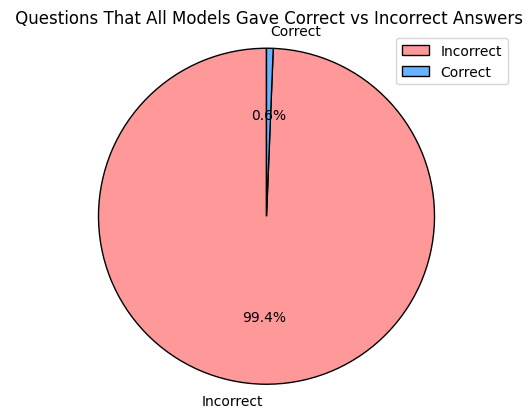

In [68]:
labels = ['Incorrect', 'Correct']
sizes = [ ensemble_model_all_correct['count'].iloc[0],ensemble_model_all_correct['count'].iloc[1]]
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.legend()
plt.title(' Questions That All Models Gave Correct vs Incorrect Answers')

plt.show()

In [69]:
all_results["all_agree"] = (
    (all_results["llema_solution"] == all_results["llama_solution"]) &
    (all_results["qwen_solution"] == all_results["llama_solution"]) &
    (all_results["mistral_solution"] == all_results["llama_solution"]) &
    (all_results["llema_solution"] != "Error Parsing Response")
)

ensemble_model_all_agree = pd.DataFrame(all_results["all_agree"].value_counts())
ensemble_model_all_agree

,count
all_agree,
False,4967
True,33


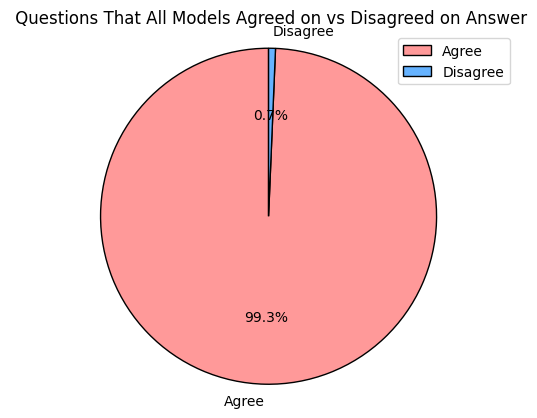

In [70]:
labels = ['Agree', 'Disagree']
sizes = [ ensemble_model_all_agree['count'].iloc[0],ensemble_model_all_agree['count'].iloc[1]]
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.legend()
plt.title(' Questions That All Models Agreed on vs Disagreed on Answer')

plt.show()

In [121]:
test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
#percent_each_leveltype['count'] = percent_each_leveltype['count'].astype(str)
#percent_each_leveltype['count'] = percent_each_leveltype['count'] + "%"
percent_each_leveltype.columns = ["Percent of Level:Type in Dataset"]

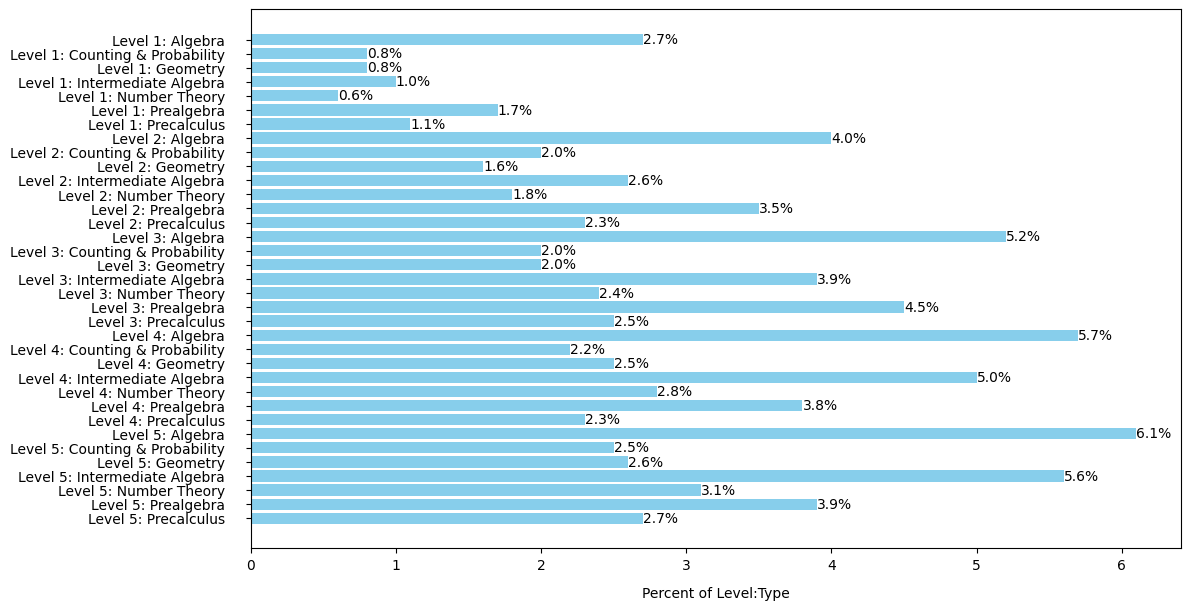

In [133]:
percent_each_leveltype = percent_each_leveltype.sort_values(by=['Level:Type'], ascending=False)
percent_each_leveltype

fig, ax = plt.subplots(figsize=(12, 7))  

bars = plt.barh(percent_each_leveltype.index, percent_each_leveltype["Percent of Level:Type in Dataset"], color = "skyblue")

ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=10) 

ax.set_xlabel("Percent of Level:Type", labelpad=10)


plt.show()


In [86]:
level_types = all_results['level:type'].unique()

all_level_types = []
questions_right = []
questions_wrong = []

percent_questions_right_total = []
percent_questions_wrong_total = []

percent_questions_right_total_raw = []

for cat in level_types:
    right_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == True)) ]["row_index"]
    right_string_row_idxquestions = ", ".join(map(str, right_row_indices_of_questions))

    wrong_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == False)) ]["row_index"]
    wrong_string_row_idxquestions = ", ".join(map(str, wrong_row_indices_of_questions))
    
    all_level_types.append(cat)

    questions_right.append(right_string_row_idxquestions)
    questions_wrong.append(wrong_string_row_idxquestions)

    percent_right = (len(right_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 
    percent_wrong = (len(wrong_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 


    percent_questions_right_total.append( str(round(percent_right*100)) +"%")
    percent_questions_wrong_total.append( str(round (percent_wrong*100)) + "%" )

    percent_questions_right_total_raw.append(percent_right)


individal_question_breakdown = pd.DataFrame(list(zip(all_level_types, questions_right, percent_questions_right_total, percent_questions_right_total_raw, questions_wrong, percent_questions_wrong_total)))
individal_question_breakdown.columns = ['Level:Type', 'Question #s Correct by All Models', 'Total Correct', 'Total Correct Raw', 'Question #s Incorrect by All Models',
'Total Incorrect']
individal_question_breakdown = individal_question_breakdown.merge(percent_each_leveltype, left_on="Level:Type", right_on="Level:Type")
individal_question_breakdown = individal_question_breakdown.sort_values(by=['Total Correct Raw'], ascending=False)
individal_question_breakdown = individal_question_breakdown[individal_question_breakdown["Total Correct Raw"] > 0]
individal_question_breakdown = individal_question_breakdown.drop(columns=["Total Correct Raw"])
individal_question_breakdown


,Level:Type,Question #s Correct by All Models,Total Correct,Question #s Incorrect by All Models,Total Incorrect,Percent of Level:Type in Dataset
1,Level 1: Algebra,"149, 179, 236, 328, 490, 498, 636, 908, 1000, ...",8%,"1, 4, 13, 19, 24, 64, 65, 70, 83, 84, 100, 102...",92%,2.7%
28,Level 1: Prealgebra,"4095, 4119, 4292",3%,"3591, 3594, 3596, 3606, 3607, 3622, 3626, 3634...",97%,1.7%
4,Level 2: Algebra,"227, 425, 580, 605, 1139",2%,"5, 12, 16, 22, 41, 42, 44, 67, 72, 76, 79, 82,...",98%,4.0%
24,Level 3: Number Theory,"3108, 3238, 3400",2%,"3058, 3059, 3065, 3068, 3074, 3076, 3077, 3088...",98%,2.4%
29,Level 3: Prealgebra,"3822, 3972, 4098",1%,"3592, 3593, 3595, 3598, 3600, 3609, 3614, 3621...",99%,4.5%
26,Level 2: Prealgebra,"4303, 4369",1%,"3584, 3597, 3602, 3605, 3616, 3617, 3619, 3630...",99%,3.5%
7,Level 2: Counting & Probability,1471,1%,"1189, 1198, 1214, 1215, 1220, 1226, 1228, 1230...",99%,2.0%
0,Level 3: Algebra,"340, 554",1%,"0, 14, 17, 18, 23, 30, 31, 35, 45, 47, 49, 52,...",99%,5.2%
27,Level 4: Prealgebra,3957,1%,"3585, 3589, 3590, 3599, 3601, 3608, 3610, 3613...",99%,3.8%
2,Level 4: Algebra,300,0%,"2, 6, 7, 8, 10, 21, 26, 29, 34, 37, 39, 43, 46...",100%,5.7%


In [78]:
categories = all_results['level'].unique()

all_categories = []
percents_correct = []
percents_incorrect = []

for category in categories:
    category_results = pd.DataFrame( all_results[ all_results['level'] == category]['all_correct'].value_counts() )
    #print(category_results)
    #print(list(category_results.index))

    if True in list(category_results.index) and False in list(category_results.index):
        num_correct = category_results['count'].iloc[0]
        num_incorrect = category_results['count'].iloc[1]
    elif True in list(category_results.index):
        num_correct = category_results['count'].iloc[0]
        num_incorrect = 0
    elif False in list(category_results.index):
        num_correct = 0
        num_incorrect = category_results['count'].iloc[0]        

    percent_correct = num_correct / (num_correct + num_incorrect)
    percent_incorrect = num_incorrect / (num_correct + num_incorrect)
    all_categories.append(category)
    percents_correct.append(percent_correct)
    percents_incorrect.append(percent_incorrect)


results_by_category = pd.DataFrame(list(zip(all_categories, percents_correct, percents_incorrect)))
results_by_category.columns = ['Level', '% Correct', '% Incorrect']
results_by_category = results_by_category.sort_values(by=['Level'])
results_by_category = results_by_category.round(2)
results_by_category

,Level,% Correct,% Incorrect
1,Level 1,0.97,0.03
4,Level 2,0.99,0.01
0,Level 3,0.99,0.01
2,Level 4,1.00,0.00
3,Level 5,0.00,1.00


In [79]:
percent_each_level = pd.DataFrame(test_dataset_df["level"].value_counts())
percent_each_level['count'] = round(percent_each_level['count'] / percent_each_level['count'].sum(), 2)
#percent_each_level['count'] = percent_each_level['count'] + "%"
percent_each_level.columns = ["percent"]
percent_each_level.percent = pd.to_numeric(percent_each_level.percent)

percent_each_level = percent_each_level.sort_values(by=['level'])
percent_each_level

,percent
level,
Level 1,0.09
Level 2,0.18
Level 3,0.23
Level 4,0.24
Level 5,0.26


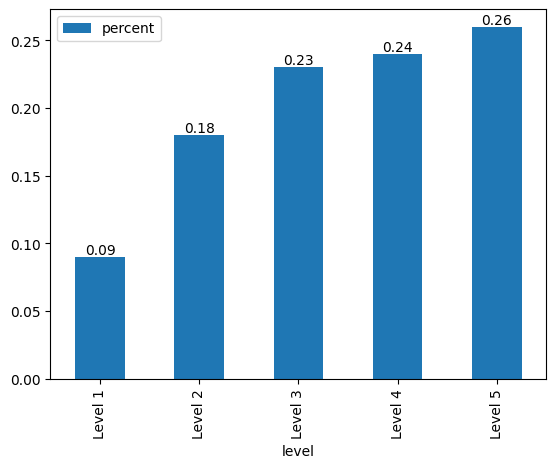

In [75]:
ax =  percent_each_level.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

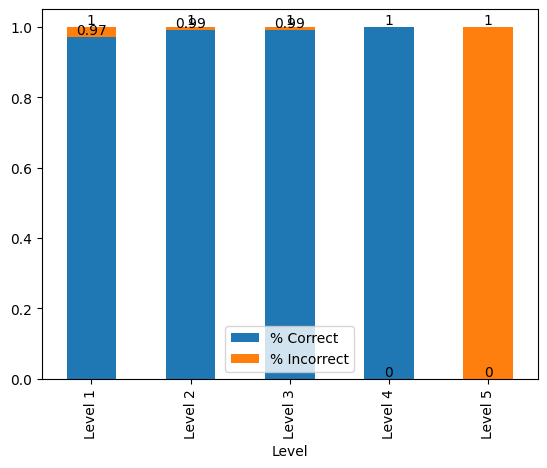

In [76]:
ax = results_by_category.plot.bar(x= 'Level',stacked= True)

for container in ax.containers:
    ax.bar_label(container)

In [77]:
categories = all_results['type'].unique()

all_categories = []
percents_correct = []
percents_incorrect = []

for category in categories:
    category_results = pd.DataFrame( all_results[ all_results['type'] == category]['all_correct'].value_counts() )
    num_correct = category_results['count'].iloc[0]
    num_incorrect = category_results['count'].iloc[1]
    percent_correct = num_correct / (num_correct + num_incorrect)
    percent_incorrect = num_incorrect / (num_correct + num_incorrect)

    all_categories.append(category)
    percents_correct.append(percent_correct)
    percents_incorrect.append(percent_incorrect)

results_by_category = pd.DataFrame(list(zip(all_categories, percents_correct, percents_incorrect)))
results_by_category.columns = ['Type', '% Correct', '% Incorrect']
results_by_category = results_by_category.sort_values(by=['Type'])
results_by_category = results_by_category.round(2)
results_by_category

IndexError: single positional indexer is out-of-bounds

In [ ]:
percent_each_type = pd.DataFrame(test_dataset_df["type"].value_counts())
percent_each_type['count'] = round(percent_each_type['count'] / percent_each_type['count'].sum(), 2)
percent_each_type.columns = ["percent"]
percent_each_type.percent = pd.to_numeric(percent_each_type.percent)
percent_each_type = percent_each_type.sort_values(by=['type'])

percent_each_type

,percent
type,
Algebra,0.24
Counting & Probability,0.09
Geometry,0.10
Intermediate Algebra,0.18
Number Theory,0.11
Prealgebra,0.17
Precalculus,0.11


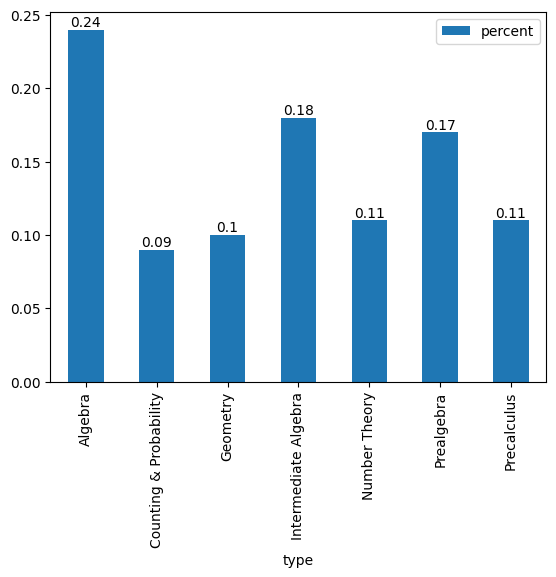

In [ ]:
ax =  percent_each_type.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

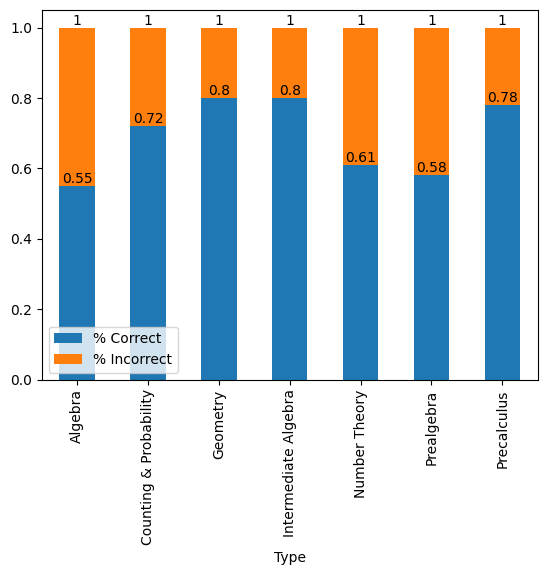

In [ ]:
ax = results_by_category.plot.bar(x= 'Type',stacked= True)

for container in ax.containers:
    ax.bar_label(container)
